In [ ]:
!pip install pandas
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install sklearn
!pip install wordcloud
!pip install scikit-multilearn
!pip install neattext
!pip install gensim

# Group Coursework

This model was chosen as it gave the best accuracy out of all the other experimented models. In addition, this model had the best F1-score. F1-score was seen as the most important metric as having a good balance between precision and recall would be the most appropriate for the use case of categorizing movies. Another metric that was considered was Hamming's Loss as this use case works with labelling the movies with multiple genres. Accuracy only considers if the full prediction is true but hammings loss considers even partially correct predictions therefore giving a better look at how well the model works.

In [7]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, multilabel_confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud
import neattext as nt
import neattext.functions as nfx
import warnings


%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 300)

In [8]:
drive_root = './MovieSummaries'

In [9]:
file_path = "{}/movie.metadata.tsv".format(drive_root)
meta = pd.read_csv(file_path, sep = '\t', header = None)

In [10]:
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [11]:
file_path_2 = "{}/plot_summaries.txt".format(drive_root)
plots = []

with open(file_path_2, 'r', encoding='utf8') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:02, 18624.03it/s]


In [12]:
movie_id = []
plot = []

for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|███████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 1084651.57it/s]


In [13]:
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [14]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

In [15]:
genres = []

for i in movies['genre']:
    genres.append(list(json.loads(i).values()))
    
movies['genre'] = genres
movies.shape

(42204, 4)

In [16]:
movies = movies[~(movies['genre'].str.len() == 0)]
movies.shape

(41793, 4)

In [17]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

In [18]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

In [19]:
descGenreCount = all_genres_df.sort_values(by=['Count'], ascending=False)[0:10]
top_genres = descGenreCount['Genre'].to_list()
top_genres

['Drama',
 'Comedy',
 'Romance Film',
 'Thriller',
 'Action',
 'World cinema',
 'Crime Fiction',
 'Horror',
 'Black-and-white',
 'Indie']

In [20]:
movies['genre'] = movies['genre'].apply(lambda x: [word for word in x if word in top_genres])

In [21]:
movies = movies[~(movies['genre'].str.len() == 0)]
movies.shape

(35382, 4)

In [22]:
movies = movies[movies['genre'].notna()]
movies.shape

(35382, 4)

In [23]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kc_di\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
movies['clean_plot'] = movies['plot'].str.lower().str.split().apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

In [25]:
# function for text cleaning
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = text.replace("\n", " ")
     # split string into tokens
    tokens = nltk.tokenize.word_tokenize(text.lower())
    # only keep strings with letters
    tokens = [t for t in tokens if t.isalpha()] 
    # lemmatize and stem words
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] 
    tokens = [stemmer.stem(t) for t in tokens]
    # remove short words, they're probably not useful
    tokens = [t for t in tokens if len(t) > 2]
     # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    cleanedText = " ".join(tokens)
    return cleanedText

In [26]:
movies['clean_plot'] = movies['plot'].apply(lambda x: clean_text(x))

# Model

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies['genre'])

# transform genres
y = multilabel_binarizer.transform(movies['genre'])

In [28]:
# Normal text tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [29]:
# Normal text train and test set
X_train, X_test, y_train, y_test = train_test_split(movies['clean_plot'], y, test_size=0.2, random_state=9)

In [30]:
# create TF-IDF features for normal text
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, classification_report

In [32]:
def test_model(model, X_train, y_train, X_test, y_test):
    clf = model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    print("Overall accuracy Score: {}".format(accuracy_score(y_test, clf_pred)))
    print("Overall Hamming Loss Score: {}".format(hamming_loss(y_test, clf_pred)))
    print(classification_report(y_test, clf_pred))
    return (clf, clf_pred)

In [33]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

In [34]:
svm_normal_clf, svm_normal_pred = test_model(svm_clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

Overall accuracy Score: 0.2033347463614526
Overall Hamming Loss Score: 0.1532287692525081
              precision    recall  f1-score   support

           0       0.61      0.44      0.51      1165
           1       0.55      0.30      0.39       747
           2       0.66      0.57      0.61      2090
           3       0.51      0.31      0.39       795
           4       0.71      0.74      0.73      3796
           5       0.80      0.60      0.69       818
           6       0.39      0.12      0.19       715
           7       0.56      0.39      0.46      1367
           8       0.56      0.41      0.48      1309
           9       0.46      0.27      0.34      1042

   micro avg       0.64      0.50      0.56     13844
   macro avg       0.58      0.42      0.48     13844
weighted avg       0.62      0.50      0.54     13844
 samples avg       0.61      0.54      0.53     13844



In [35]:
svm_normal_pred

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 1, 1]])

In [36]:
def convert_to_text(pred):
    genres = []
    for i, item in enumerate(pred):
        if(item == 1):
            genres.append(top_genres[i])
    return genres    

for pred in svm_normal_pred:
    print(convert_to_text(pred))
    

['Romance Film', 'Action']
['Romance Film', 'Action']
['Crime Fiction']
['Romance Film']
['Action']
['Romance Film']
['Action']
['Action']
['Black-and-white']
['Romance Film']
['Action']
['Action']
['Action']
['Action']
['Romance Film']
['Drama', 'Romance Film']
['Black-and-white']
[]
['World cinema']
['Action']
['Comedy', 'Action', 'Horror']
['Comedy', 'Action']
['Romance Film']
['Action']
['Action']
['Action']
['Action']
['Action']
['Romance Film']
['Romance Film', 'Action']
['Action']
['Action']
['Action', 'Horror']
['Drama', 'Thriller', 'Action', 'Black-and-white', 'Indie']
['Drama', 'Romance Film', 'Black-and-white']
['Thriller', 'Black-and-white']
['Drama']
['World cinema']
['Drama', 'Action']
['Action']
['Comedy']
['Action']
['Action']
['World cinema']
['Romance Film', 'Horror']
['World cinema']
['Romance Film', 'Action']
['Drama']
['Action']
['Romance Film']
[]
['Action', 'Horror']
['Action']
['Thriller', 'Action']
['Action', 'Crime Fiction']
['Romance Film']
['Action', 'World 

['Romance Film']
['Romance Film', 'Action', 'Horror']
['Drama', 'Thriller', 'Black-and-white']
['World cinema']
['Action', 'Horror', 'Indie']
['Romance Film']
['World cinema']
['Action']
['Action']
['Romance Film', 'Action', 'Indie']
['Romance Film', 'Action']
['Action', 'Horror']
['Romance Film']
['Action']
['Drama', 'Black-and-white']
['Action']
['Action']
['Action']
['Action']
[]
['Thriller', 'Action']
['Thriller']
['Black-and-white']
['Action', 'Black-and-white']
['Black-and-white']
['Action']
[]
['Romance Film', 'World cinema']
['Action']
['Action']
['Action', 'Black-and-white', 'Indie']
['Action']
['Romance Film']
['Action']
['Action', 'Crime Fiction']
['Action', 'Black-and-white']
['World cinema', 'Crime Fiction']
['Action']
['Action']
['Action']
['Romance Film', 'Action']
['Action']
['Romance Film', 'Action']
['Action', 'Black-and-white']
['Romance Film']
['Romance Film', 'Action']
['World cinema', 'Indie']
['Romance Film', 'Action', 'Horror']
['Romance Film']
['Indie']
['Actio

['Action']
[]
['World cinema']
['Action', 'Indie']
['Romance Film']
['Action', 'Horror']
['Action', 'World cinema']
['Romance Film', 'World cinema', 'Crime Fiction', 'Horror']
[]
[]
['Romance Film', 'Action']
['Action']
['Romance Film']
['Drama', 'Thriller', 'World cinema', 'Black-and-white']
['Romance Film', 'Horror']
['Action', 'Horror']
['Action', 'Crime Fiction', 'Indie']
['Romance Film']
[]
['Action', 'Black-and-white']
['Romance Film', 'World cinema']
['Romance Film', 'Action']
['Romance Film']
['Thriller']
['Romance Film', 'Action', 'Horror']
['Action']
['Drama', 'Black-and-white']
['Black-and-white']
['World cinema', 'Black-and-white']
['Romance Film', 'Action']
['Comedy', 'Action']
['World cinema']
['Action']
['World cinema', 'Black-and-white']
['Romance Film']
['Thriller', 'Action']
['Romance Film', 'Action']
['Action']
[]
['Romance Film', 'Horror']
['Action', 'Horror']
['Comedy', 'Romance Film', 'Crime Fiction']
['Action']
['Action', 'Horror']
['Thriller', 'Action']
['Action

['Action']
['Action', 'Horror']
['Action']
['Drama', 'Thriller', 'Indie']
['Action']
['Action', 'Indie']
['Action', 'Horror']
['Action']
['Comedy', 'Action']
['Romance Film']
[]
['Drama', 'Action', 'Black-and-white']
['Romance Film']
['Romance Film']
['Action', 'Black-and-white']
['Action']
['Action']
['Action']
[]
['Action']
['Black-and-white']
['Action']
['Comedy', 'Action']
['Romance Film']
['Action']
['Action']
['Action']
['Romance Film']
[]
['Drama', 'Action']
['World cinema']
['Romance Film', 'Action', 'Horror']
['Romance Film']
['Drama', 'Black-and-white']
['World cinema']
['Action', 'Crime Fiction']
['Romance Film', 'Indie']
['World cinema']
['Action']
['Action', 'Horror']
['Romance Film', 'World cinema']
['Drama', 'Romance Film', 'Indie']
['Action']
['Drama', 'Romance Film']
['Action']
['Romance Film', 'Action']
['Action']
[]
['Comedy', 'Romance Film', 'Action']
['Action']
['Action']
['Action']
['World cinema']
['Action']
['Action']
['Drama', 'Action', 'Horror']
[]
['Comedy', 

[]
['Drama']
['Action']
['Action']
['Action', 'Horror']
['Romance Film', 'Action', 'Horror']
['Action']
['Romance Film']
['Drama', 'Action']
['Action', 'Indie']
['Action']
[]
['Action']
['Romance Film']
['Action', 'Crime Fiction']
['Action', 'Black-and-white']
['Drama']
['Romance Film']
['Action', 'World cinema', 'Black-and-white']
[]
['Romance Film']
['Action']
['Action', 'Horror']
['Action', 'Black-and-white']
['Drama', 'Action']
['World cinema']
[]
['Comedy', 'Romance Film']
['Romance Film', 'Horror']
[]
['Romance Film']
[]
['Comedy', 'Romance Film']
['Drama']
['Romance Film']
['World cinema']
['Comedy', 'Action']
['Romance Film']
['Drama', 'Action']
['Romance Film']
['Action']
['Action', 'Horror']
['Action', 'Black-and-white']
['Thriller', 'Action']
['Action', 'Horror']
['Comedy', 'Romance Film']
['Action', 'Horror']
[]
['Action', 'Black-and-white']
['Action']
['Drama', 'World cinema']
['Action', 'Indie']
['World cinema']
['Action']
['Action', 'Horror']
['Action', 'Indie']
['Romanc

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load

In [38]:
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(max_df=0.5, max_features=20000)),
                            ('model', svm_clf)])

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, max_features=20000)),
                ('model',
                 OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1))])

In [40]:
dump(pipeline, filename="text_classification.joblib")

['text_classification.joblib']

# Model as a Web Service

Flask was chosen as the model serving option for this use case of labelling movies with their genres. As the chosen model uses the sklearn library, TorchServe was found to not be a suitable serving model option as it only supports PyTorch models. Tensorflow Serving additionally mostly supports Tensorflow models and has the capability to support other deep learning models. For the current state, the use of the movie genre prediction model would take inputs from one person or company for their database and therefore the need for multiple copies of the models and other scalable features would not be needed right now. 

In [ ]:
!python movieGenre_prediction.py 

# Testing

To ensure that the endpoint is able to function properly a series of tests were implemented using `pytest`, a python testing framework. A series of different combinations and formats of input data were tested to make sure that the endpoint was robust and able to handle different inputs.

The correct format of input data is a list of JSON objects, each containing a title and plot:

```json
[    
    {
         "title": "Night of the Wolf: Late Phases",
         "plot": "When deadly beasts attack from the forest, it is up to a grizzled veteran to uncover what the residents of a secluded retirement community are hiding."
    },
    {
        "title": "Stake Land",
        "plot": "In a world of vampires, an expert vampire hunter and his young protégé travel toward sanctuary."
    }
]
```

### Test cases

After initial tests of the different test cases it was found that the endpoint failed all tests where data wasn't exactly as its supposed to be. 

The test cases are described below:

| Name | Input Data | Expected Outcome | Test Result |
| ---- | ---- | ---- | ---- |
| `test_valid_body_single` | Valid data, list containing single set of data with valid title and plots | `200` status code, with predicted genres | Pass |
| `test_valid_body_multiple` | Valid data, list containing two sets of data with valid title and plots | `200` status code, with predicted genres | Pass |
| `test_invalid_content_type` | Valid data, list containing set of data with valid plot and title but wrong `Content-Type` header | `422` status code, with error message | Fail |
| `test_invalid_body_missing_title` | Invalid data, list containing set of data with valid plot but missing title | `422` status code, with error message | Fail |
| `test_invalid_body_missing_title` | Invalid data, list containing set of data with valid plot but missing title | `422` status code, with error message | Fail |
| `test_invalid_body_missing_plot` | Invalid data, list containing set of data with valid title but missing plot | `422` status code, with error message | Fail |
| `test_invalid_body_invalid_title` | Invalid data, list containing set of data with valid plot and  invalid title | `422` status code, with error message | Fail |
| `test_invalid_body_invalid_plot` | Invalid data, list containing set of data with valid title and  invalid plot | `422` status code, with error message | Fail |
| `test_invalid_body_invalid_empty` | Invalid data, empty list | `422` status code, with error message | Fail |

To fix this, a series of checks were implemented in the endpoint method. The checks made sure the request contained the correct headers (Content-Type), did not contain an empty list of input data and all of the required fields were present and valid. After implementing all of the checks the tests all passed.

In [3]:
!pytest

============================= test session starts =============================
platform win32 -- Python 3.8.5, pytest-6.1.1, py-1.9.0, pluggy-0.13.1
rootdir: D:\nlp\group
collected 8 items

test_valid_body.py ........                                              [100%]

============================== warnings summary ===============================
C:\Users\subha\anaconda3\lib\site-packages\pyreadline\py3k_compat.py:8
  C:\Users\subha\anaconda3\lib\site-packages\pyreadline\py3k_compat.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
    return isinstance(x, collections.Callable)

-- Docs: https://docs.pytest.org/en/stable/warnings.html
======================== 8 passed, 1 warning in 17.62s ========================


# Performance of the service 

To check the performance, we ran the service with different number of movies. Using Postman, we were able to see how long the endpoint took to run for each number and how well the model labelled the new inputs. All the movie titles and synposis used were taken from https://www.imdb.com/

| Number of Movies | Time Elapsed |
| ---- | ---- | 
| 1 | 19 ms | 
| 5 | 56 ms | 
| 10 | 66 ms | 
| 25 | 108 ms |
| 50 | 225 ms |
| 100 | 431 ms |

From the table it can be seen that the web service performs well with up to 100 inputs, only taking around 4 seconds. It also shows a trend and relationship between the number of inputs and the time taken to return the predictions, where the time taken doubles when the number of inputs doubles. Therefore it can be inferred and calculated that 1000 inputs would take just under a minute to return predictions, which can still be seen as a reasonable time period given the size of the input. This performance test was done with only one user using the service, following the use case. However if the service and model was expanded to be used by mutiple users, there may be a massive affect on the performance and therefore could require the use of an MLOps platform to help with scalability.   

When looking at the results shown in the response.json file and comparing to the actual genres given by IMDb, the model overall does a good job at labelling the movies. However there is still room for improvement with the model occasionally predicting wrong genres, which can be done by training the model with more data. The model also misses genres and for some movies there are no genres returned, which could be due to the constraints of having only 10 genres. Therefore another improvement could be to include more genres and train the model with these labels. 

# Monitoring functionality

We stored the user input and its predicted genres to a csv file.
Below are the data exploration of the respective data.

In [32]:
import pandas as pd
import math
import nltk

In [41]:
userMovies = pd.read_csv("userMovies.csv", sep = ',', header = None)
userMovies.columns = ["Synopsis", "Pred_genre"]

In [42]:
for i in userMovies.index:
    #splitTemp = i.split(",")
    #print(type(userMovies.at[i, "Pred_genre"]))
    #print(userMovies.at[i, "Pred_genre"])
    if isinstance(userMovies.at[i, "Pred_genre"], str):
        userMovies.at[i, "Pred_genre"] = userMovies.at[i, "Pred_genre"].split(", ")
    else:
        userMovies.at[i,"Pred_genre"] = "Undefined"
        userMovies.at[i, "Pred_genre"] = userMovies.at[i, "Pred_genre"].split(", ")
userMovies

Synopsis  \
0    Two friends are searching for their long lost ...   
1    A man blinded by toxic waste which also enhanc...   
2    MMA fighter Cole Young seeks out Earth's great...   
3    A group of high-school students, who are infus...   
4    When a diabolical pirate above the sea steals ...   
..                                                 ...   
195  A chaotic battle ensues between Jerry Mouse, w...   
196   In New York City's late nineties, a young asp...   
197  When a man goes in to have virtual vacation me...   
198  A former Roman General sets out to exact venge...   
199  A heavy-metal drummer's life is thrown into fr...   

                              Pred_genre  
0                              ['Drama']  
1    ['Action', 'Drama', 'World cinema']  
2                             ['Action']  
3                              ['Drama']  
4                             ['Comedy']  
..                                   ...  
195                           ['Comedy']  
196                  ['Comedy', 'Drama']  
197                          [Undefined]  
198                           ['Action']  
199                            ['Drama']  

[200 rows x 2 columns]

In [43]:
new_genres = []

for i in userMovies['Pred_genre']:
  new_genres.append(i)
    
userMovies['genre_new'] = new_genres

In [44]:
all_genres = sum(new_genres,[])
len(set(all_genres))

10

In [45]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

Count for each genre

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

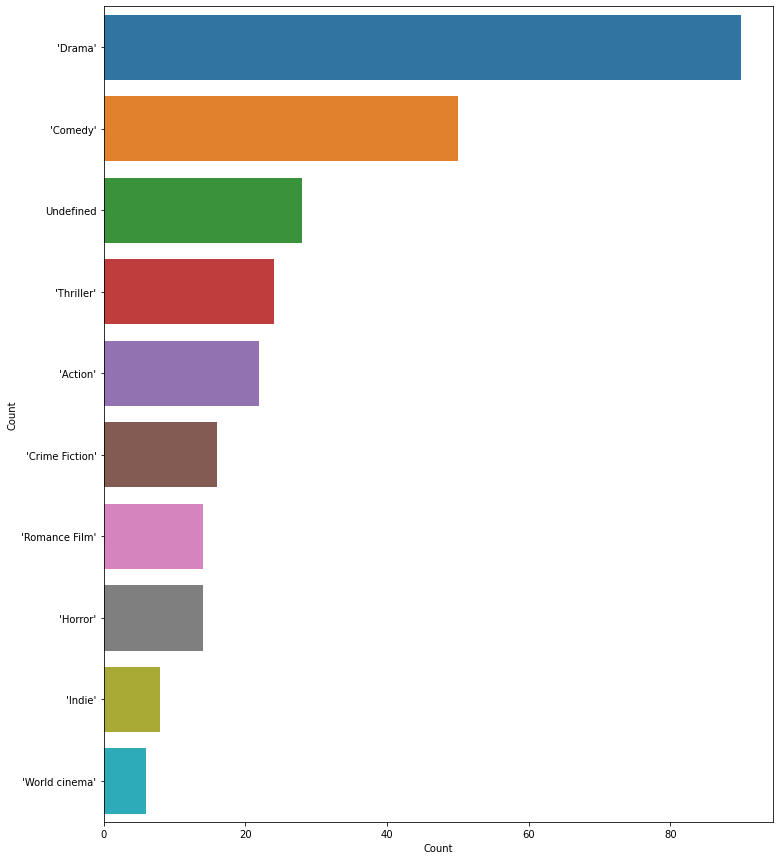

In [47]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()